All of the contents of this cell are courtesy of pyrunner.com "Compressed Sensing in Python" Posted May 26 2016 in Mathematics, Python

- Some updates were made to the original code to correct for outdated code
- Plotting was also added

# Compressed Sensing

<font size="4">In this post I’ll be investigating compressed sensing (also known as compressive sensing, compressive sampling, and sparse sampling) in Python. Since the idea of compressed sensing can be applied in wide array of subjects, I’ll be focusing mainly on how to apply it in one and two dimensions to things like sounds and images. Specifically, I will show how to take a highly incomplete data set of signal samples and reconstruct the underlying sound or image. It is a very powerful technique.</font>

# $L^{1}$ vs $L^{2}$

<font size="4">As you might know, there are many differernt types of norms. Perhaps the most common and widely recognized one is the $L^{2}$ norm:

<font size="4"><h1><center>$||\vec{x}||_{2} = (\sum\limits_{i=0}^{n} x_{i}^{2})^{1/2}$</center></h1></font>

The $L^{2}$ norm is nice becuase it is easily calculated, easily differentiated, and it has intuitive appeal (e.g., the norm of a vector is its length). A lot of very important algorithms and methods rely on the $L^{2}$, including least squares fitting.

That said, the $L^{2}$ norm isn't the goto solution for everything. The other norms also have many interesting and useful properties. Consider the $L^{1}$ norm:

<font size="4"><h1><center>$||\vec{x}||_{1} = \sum\limits_{i=0}^{n} |x_{i}|$</center></h1></font>

Instead of squaring each element, it simply takes its absolute value. Although the absolute value is annoying in the sense that it often introduces discontinuities in its derivatives, it does have some unique properties when compared to the squaring that takes place in the $L^{2}$ norm. Compressed sensing is all about exploiting these properties.

Let’s visualize some data with Python to see what I’m talking about. </font>

In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy.optimize as spopt
import scipy.fft as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image
from PIL import ImageOps
import pdb
import os

%matplotlib inline

<font size="4">First what we’re going to do is create some arbitrary linear data including some noise. Let’s use the made-up equation:
<h1><center>$y = \dfrac{1}{5}x+3+\epsilon$</center></h1>

where $\epsilon$ is some normally distributed error with standard deviation $\sigma$=0.1.</font>

In [14]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

<font size="4">Now let's fit two lines to the data samples. For the first line, we'll use the $L^{1}$ norm as the criterion for a good fit: for the second line, we'll use the $L^{2}$ norm. </font>

Optimization terminated successfully.
         Current function value: 1.271875
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 0.185281
         Iterations: 68
         Function evaluations: 133


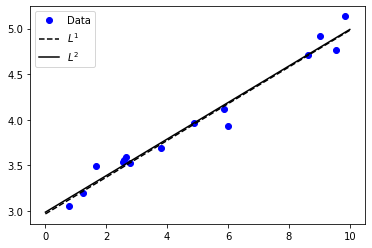

In [15]:
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

# Create data from fits
xf = np.arange(0,10+1)
yf1 = xopt1[0]*xf+xopt1[1]
yf2 = xopt2[0]*xf+xopt2[1]

#Plot the results
plt.plot(x,y,'bo',label='Data')
plt.plot(xf,yf1,'k--',label='$L^{1}$')
plt.plot(xf,yf2,'k-',label='$L^{2}$')
plt.legend()


<font size="4">Notice that both of the fits seem to do a pretty good job fitting the data. Sure, they don’t line up exactly, but they both are reasonable approximations given the noise.

Now, let’s get a tad crazy and add some outliers. In other words, let’s perturb a couple of the points, moving them far away from the lines. This isn’t actually all that out of the ordinary if you think about it. Outliers frequently occur in real world data, causing all kinds of headaches.</font>

Optimization terminated successfully.
         Current function value: 8.271875
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 22.439561
         Iterations: 49
         Function evaluations: 97


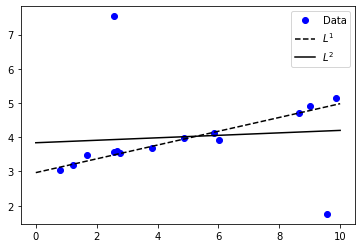

In [16]:
# adjust data by adding outlyers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

# Create data from fits
xf = np.arange(0,10+1)
yf12 = xopt12[0]*xf+xopt12[1]
yf22 = xopt22[0]*xf+xopt22[1]

#Plot the results
plt.plot(x,y2,'bo',label='Data')
plt.plot(xf,yf12,'k--',label='$L^{1}$')
plt.plot(xf,yf22,'k-',label='$L^{2}$')
plt.legend()

<font size="4">When we re-plot the $L^{1}$ and $L^{2}$ fits we see something interesting: the $L^{1}$ fit remained true to the overall trend in the data, while the $L^{2}$ fit seemed to get "corrupted" by the outliers. Why does this happen? It comes down to the fact that $L^{2}$ gets squared, while $L^{1}$ error does not. When you fit a line to data using an $L^{2}$ interpretation of error, the displacement of outliers has a disproportional impact because their already-big errors are getting squared. Just look at the distance of the two outliers in our example and imagine squaring them - of course it's not surprising that the $L^{2}$ line gets skewed!

However, when using an $L^{1}$ interpretation of error, the outliers contribute no more than their displacement. The result is a cleaner fit that more closely mathes our intuition of what a good fit should look like. It's this interesting property that opens the door to compressed sensing. </font>

# Reconstruction of a Simple Signal

<font size="4">In this example (borrowed from Kutz1), we will create an artificial sound wave, sample 10% of it, and reconstruct the original signal from the sample of 10%. This is one dimensional compressed sensing.

First, create a signal of two sinusoids</font>

(0.0, 500.0)

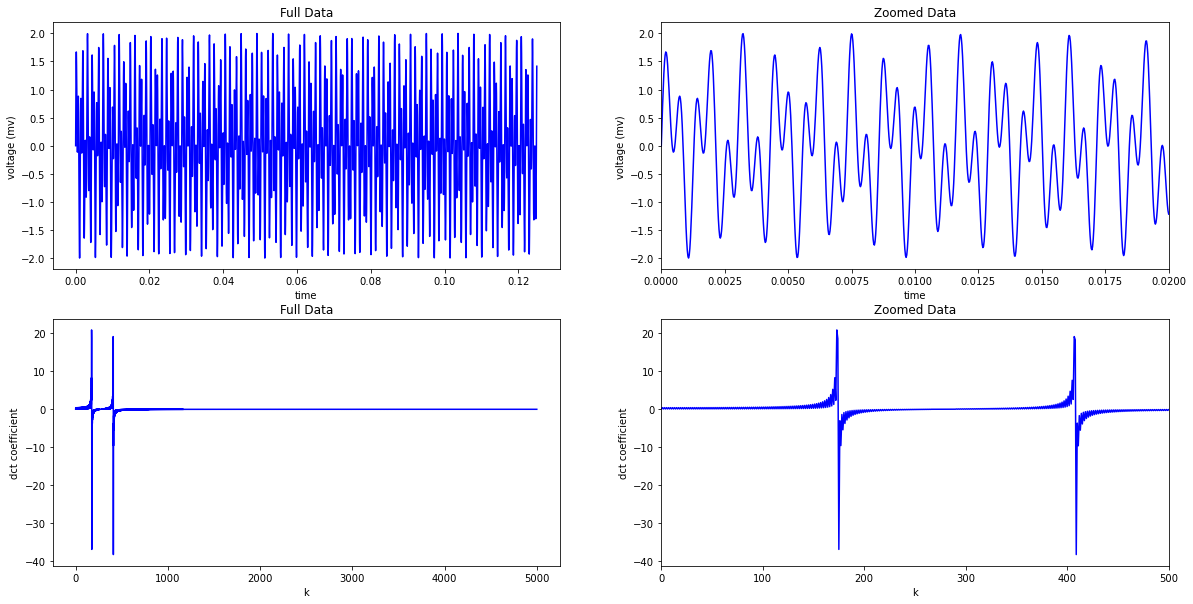

In [17]:
# sum of two sinusoids
n = 5000 #Number of samples
t = np.linspace(0, 1/8, n) #time sampling 
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho') #Discrete cosine transform

k = np.arange(0,n,1) #not properly scaled but that is okay

plt.rcParams["figure.figsize"] = (20,10)

# using the variable axs for multiple Axes
plt.subplot(2,2,1)
plt.plot(t,y,'b-')
plt.xlabel('time')
plt.ylabel('voltage (mv)')
plt.title('Full Data')

plt.subplot(2,2,2)
plt.plot(t,y,'b-')
plt.xlabel('time')
plt.ylabel('voltage (mv)')
plt.title('Zoomed Data')
plt.xlim([0,0.02])

plt.subplot(2,2,3)
plt.plot(k,yt,'b-')
plt.xlabel('k')
plt.ylabel('dct coefficient')
plt.title('Full Data')

plt.subplot(2,2,4)
plt.plot(k,yt,'b-')
plt.xlabel('k')
plt.ylabel('dct coefficient')
plt.title('Zoomed Data')
plt.xlim([0,500])

<font size="4">In the plots above, we see that the signal has a clear pattern, yet is non-trivial. The plots in the top row are of the signal in the temporal domain at different scales. The plots in the bottom row are of the signal in the spectral domain (i.e., the signal’s frequency content). Considering the frequency domain in particular, we note that the spectrum is mostly zero except for the two spikes representing the two sine frequencies.

Now imagine sampling 10% of the temporal signal (see below). You’d have a data set that, to the naked eye, would look like nonsense. The underlying signal is would still be the same, as would be its frequency content (mostly zeros, with the exception of two spikes). One might ask if it is somehow possible to extract those two dominant frequencies from the incomplete data so that we might reconstruct the signal? The answer is yes!</font>

(0.0, 0.025)

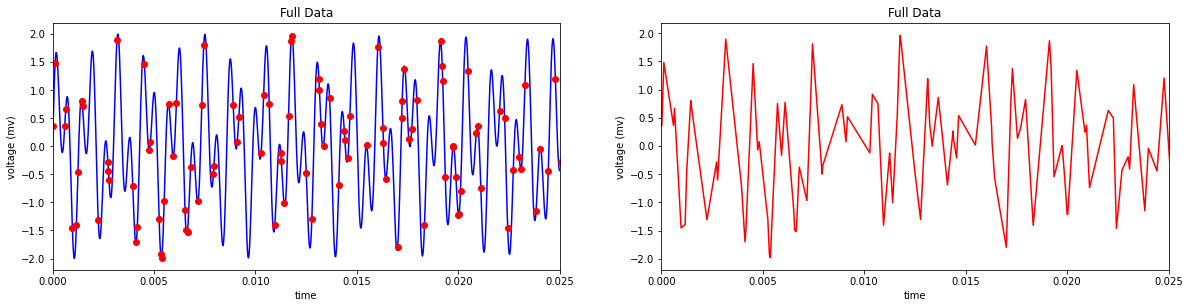

In [18]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

# using the variable axs for multiple Axes
plt.subplot(2,2,1)
plt.plot(t,y,'b-',t2,y2,'ro')
plt.xlabel('time')
plt.ylabel('voltage (mv)')
plt.title('Full Data')
plt.xlim([0,0.025])

plt.subplot(2,2,2)
plt.plot(t2,y2,'r-')
plt.xlabel('time')
plt.ylabel('voltage (mv)')
plt.title('Full Data')
plt.xlim([0,0.025])

<font size="4">Compressed sensing in this context is made possible by the fact that the signal’s frequency content is highly sparse. This is where the $L^{1}$ norm comes into play. What we want to do is, out of all possible signals, locate the simplest one that matches up with the known data. In other words, we want to use a minimization routine to find a set of frequencies satisfying two conditions: (a) the underlying signal matches up exactly (or as closely as possible) with that of our data; and (b) the $L^{1}$

norm of the frequencies is minimized. Such a routine will yield a sparse solution – exactly what we want.

In Python, there are a couple ways to accomplish this. Perhaps the easiest is to utilize the convex optimization library [CVXPY](https://www.cvxpy.org/). Use the code below to minimize the norm of the signal’s frequencies with the constraint that candidate signals should match up exactly with our incomplete samples.</font>



In [19]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A@vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jun 23 03:10:21 PM: Your problem has 5000 variables, 1 constraints, and 0 parameters.
(CVXPY) Jun 23 03:10:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 23 03:10:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 23 03:10:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 23 03:10:21 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 23 03:10:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

<font size="4">You might be asking: what the hell is that A matrix? Well, it’s the key to the whole party. Let me explain.

In order to perform the minimization, we must somehow finagle our problem into a linear system of equations:

<font size="4"><h1><center>$Ax = b$</center></h1></font>

Specifically, we want to derive a matrix A
that can be multiplied with a solution candidate x to yield b, a vector containing the data samples. In the context of our current problem, **the candidate solution x exists in the frequency domain**, while the known data b exists in the temporal domain. Clearly, the matrix A performs both a sampling and a transformation from spectral to temporal domains.

Compressed sensing really comes down to being able to correctly derive the A
operator. Fortunately, there’s a methodology. Start off by letting f be the target signal in vector form (if your signal is 2-dimensional or higher, flatten it) and $\phi$ be the sampling matrix. Then:

<font size="4"><h1><center>$b=\phi f$</center></h1></font>

Now let $\psi$ be the matrix that transforms a signal from the spectral domain to the temporal domain. Given the solution x in the frequency domain, it follows that:

<font size="4"><h1><center>$\psi x= f$</center></h1></font>

Combining the two equations yields:

<font size="4"><h1><center>$Ax = b$ where $A\equiv \phi \psi$ </center></h1></font>

So, A is simply made up of rows sampled from the domain transform matrix ψ. The ψ matrix is easy to construct – it is the inverse discrete cosine transform acting upon the columns of the identity matrix. The matrix product ψx is the equivalent to doing idct(x).

Now that we’ve constructed the A
matrix and run the minimization, we can reconstruct the signal by transforming the solution out of the frequency domain and back into the temporal. Below, on the left, is the original signal and its frequency content. On the right is our L1 approximation. I’d say that’s pretty good for only using 10% of the data! </font>

(0.0, 500.0)

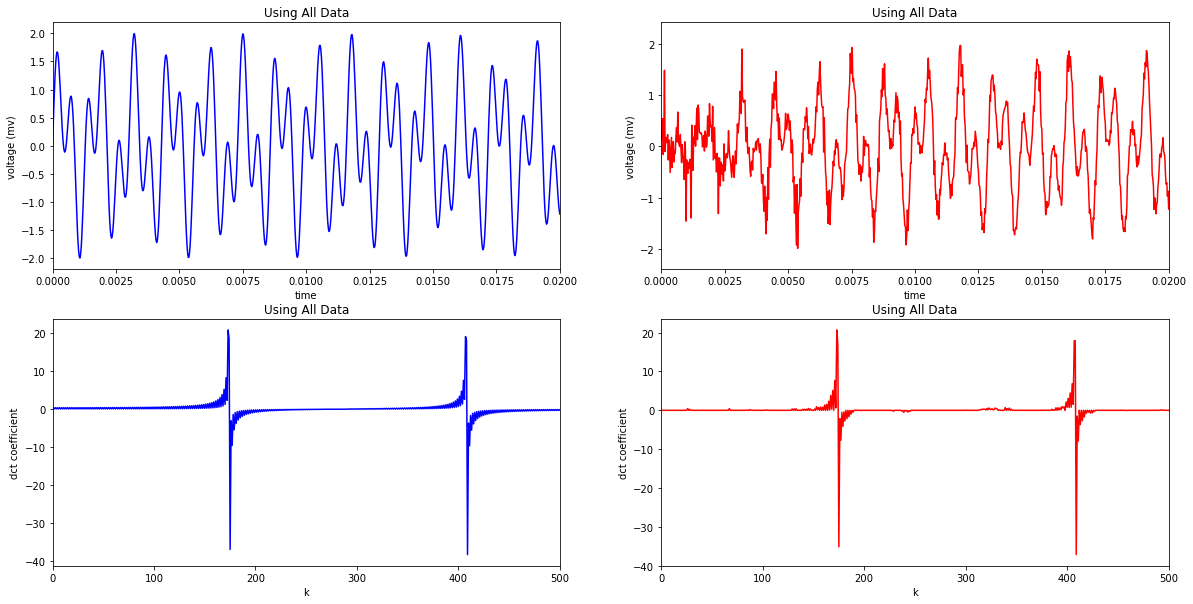

In [20]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

plt.subplot(2,2,1)
plt.plot(t,y,'b-')
plt.xlabel('time')
plt.ylabel('voltage (mv)')
plt.title('Using All Data')
plt.xlim([0,0.02])

plt.subplot(2,2,3)
plt.plot(k,yt,'b-')
plt.xlabel('k')
plt.ylabel('dct coefficient')
plt.title('Using All Data')
plt.xlim([0,500])

plt.subplot(2,2,2)
plt.plot(t,sig,'r-')
plt.xlabel('time')
plt.ylabel('voltage (mv)')
plt.title('Using All Data')
plt.xlim([0,0.02])

plt.subplot(2,2,4)
plt.plot(k,x,'r-')
plt.xlabel('k')
plt.ylabel('dct coefficient')
plt.title('Using All Data')
plt.xlim([0,500])

<font size="4">One problem that stands out is that the quality of the reconstruction degrades noticeably at and around t=0. This is probably due to our sample interval violating the periodic boundary condition requirements of the cosine transform. Of course, given an arbitrary signal sample without any prior knowledge of its nature, it would be hard not to violate periodic boundary conditions. The good news is that now we have some very clear indications of the true signal’s frequencies. If desired, we could go back and resample the signal within an interval that satisfies periodic boundaries.</font>

# Reconstruction of an Image (a 2D Signal)

<font size="4">Now let’s use what we learned from the 1-dimensional case to do compressed sensing in 2-dimensions. This is where the real fun begins because we can now try and reconstruct images.

Below, we will use exactly the same methodology as before to randomly sample and reconstruct the image Waterfall by M. C. Escher (approx. 1200 by 1600 pixels). Due to memory limitations imposed by the A

matrix, we’ll start off by considering a downsized version of the image (approx. 50 by 65 pixels). In the section that follows we’ll extend the routine to handle large images.

Note that SciPy doesn’t provide 2D versions of dct or idct. However, they can be easily constructed by recognizing that the 2D discrete cosine transform is nothing more than a dct acting upon the rows of x
followed by a second dct action upon its columns (or vice versa): 

<font size="4"><h1><center>$dct(dct(x^{T})^{T} \equiv dct(dct(x)^{T})^{T}$</center></h1></font>

As a personal preference, I like to tell SciPy’s dct and idct methods to act on the columns of a matrix (as opposed to the default behavior of acting on the rows). First of all, this keeps the Python code consistent with that of MATLAB. Second, it makes building matrix operators more intuitive (to me at least). For example, if we let Y be an m by n matrix, with $I_{m}$ and $I_{n}$ being identity matrices of size m and n respectively, then 

<font size="4"><h1><center> $dct(Y, axis=0) \equiv dct(I_{m}, axis=0) \cdot Y$ (MATLAB default)</center></h1></font>

whereas 

<font size="4"><h1><center> $dct(Y, axis=1) \equiv Y\cdot dct(I_{m}, axis=0) $ (Scipy default)</center></h1></font>

Either version can be made to work, but I feel like the first one is cleaner because it naturally keeps the matrix operator in front of the operand. Whenever I refer to the dct or idct, assume that I mean the axis=0 variety.
</font>

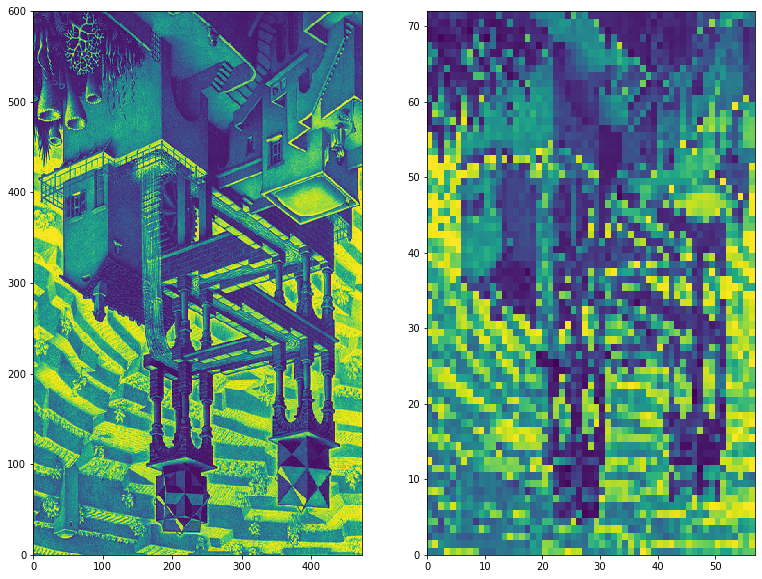

In [21]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image 
cwd = os.getcwd()#Gets current working directory
imgPath = os.path.join(cwd,"images","escher_waterfall.jpg") #Creates path to image
im = ImageOps.grayscale(Image.open(imgPath)) #Converts to grayscale
Xorig= np.asarray(im) #Converts to array

#Downsize for speed
X = spimg.zoom(Xorig, 0.12)
ny,nx = X.shape

plt.subplot(1,3,1)
plt.pcolor(Xorig)

plt.subplot(1,3,2)
plt.pcolor(X)

<font size="4"> As in the previous section, we’ll take a random sample of image indices, forming our b matrix. Then, we’ll generate our A matrix.

Creating the A matrix for 2D image data takes a little more ingenuity than it did in the 1D case. In the derivation that follows, we’ll use the Kronecker product $\otimes$ and the fact that the 2D discrete cosine transform is separable to produce our operator A.
    
Let X be an image in the spectral domain and $D_{i} = idct(I_{i})$ where $I_{i}$ is the identity matrix of size i. Then:
    
<font size="4"><h1><center> $idct2(X) = idct(idct(X^{T})^{T})= D_{m}(D_{n}X^{t})^{T}= D_{m}XD_{n}^{T}$</center></h1></font>   
    
Really all that is happening is that $D_{m}$ takes transform along one axis and $D_{n}$ takes transform along the other axis. As described here these matrices are analogous to the ifft matrix which can be used to take the ifft
    
If vec(X) is the vector operator the stacks columns of X on top of each other, then: 
    
<font size="4"><h1><center> $ vec(D_{m}XD_{n}^{T}) = (D_{n} \otimes D_{m}) vec(X) = (D_{n} \otimes D_{m}) x$ where  $x\equiv vec(X)$</center></h1></font>   
    
Clearly, the Kronecker product is our desired transformation matrix $\psi$. Therefore, our matrix A becomes $A=\phi (D_{n} \otimes D_{m})$, where $\phi$ is the sampling matrix. You can calculate the Kronecker product in Numpy with numpy.kron. The main problem with this method is that the Kronecker product can become truly massive very quickly. If your target image is m by n and you’re taking k samples, then the A matrix has a size of $(mnk)^{2}$. That said, for small images it will be fine.
    

</font>

In [22]:
# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# do L1 optimization
vx = cvx.Variable(nx * ny) #These are the variables we are trying to solve for
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A@vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jun 23 03:10:49 PM: Your problem has 4104 variables, 1 constraints, and 0 parameters.
(CVXPY) Jun 23 03:10:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 23 03:10:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 23 03:10:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 23 03:10:49 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 23 03:10:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

<font size="4">Reconstruct the signal and visualize! </font>

(0.0, 72.0)

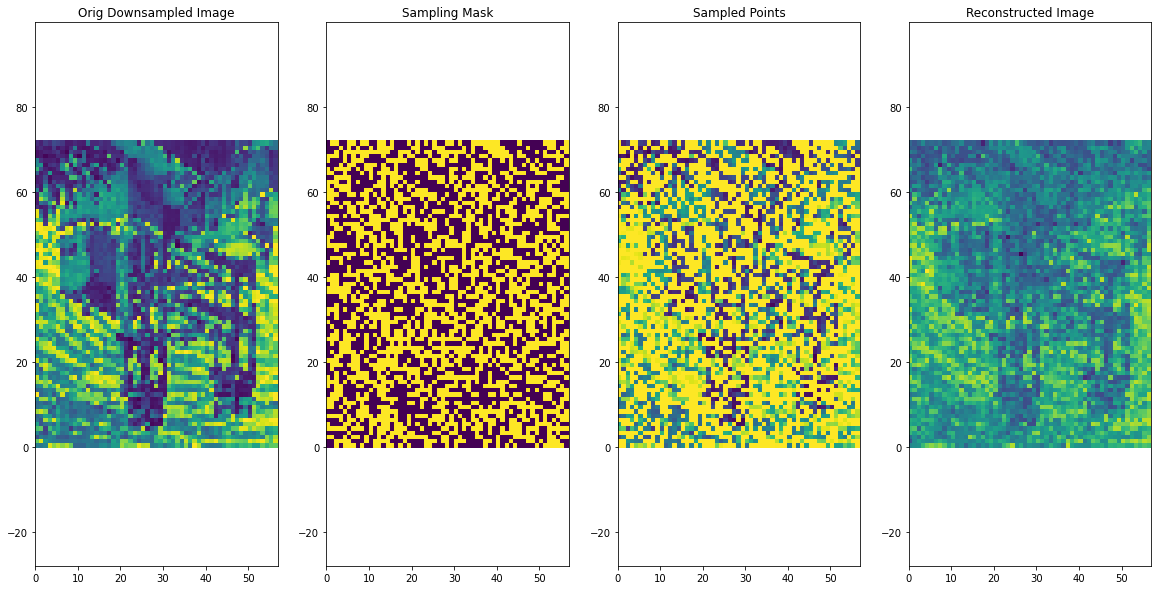

In [23]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

# create images of mask (for visualization)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]

plt.subplot(1,4,1)
plt.pcolor(X)
plt.title('Orig Downsampled Image')
plt.axis('equal')
plt.xlim(0,nx);plt.ylim(0,ny)

plt.subplot(1,4,2)
plt.pcolor(mask)
plt.title('Sampling Mask')
plt.axis('equal')
plt.xlim(0,nx);plt.ylim(0,ny)

plt.subplot(1,4,3)
plt.pcolor(Xm)
plt.title('Sampled Points')
plt.axis('equal')
plt.xlim(0,nx);plt.ylim(0,ny)

plt.subplot(1,4,4)
plt.pcolor(Xa)
plt.title('Reconstructed Image')
plt.axis('equal')
plt.xlim(0,nx);plt.ylim(0,ny)

<font size="4"> Okay, the results aren’t fabulous. The original image on the far left is barely intelligible as it is. Resolution was low, so we had to take a large-ish sample of 50% (the boolean mask is shown middle left; the masked image is middle right). Regardless, it is clear the procedure worked: the reconstructed image on the far right definitely approximates the original, be it poorly. </font>

# Optimization and Scalability

<font size="4"> Considering our working proof-of-concept, there are a lot of ways it might be improved. The Kronecker-based method, although easy to implement, proves unusable for large images. What other methods are there?

Convex optimization using CVXPY isn’t necessarily the only way to find the L1 minimum. A little bit of online research led me to the L-BFGS algorithm6 and its variant, the OWL-QN3. The OWL-QN algorithm is of particular interest to us, as it allows one to fit a $L^{1}$ regularized model by minimizing a function of the form:

<font size="4"><h1><center>$f(x) = g(x) + C||x||_{1}$</center></h1></font> 
    
where f is a differentiable convex loss function and C is a constant. In our case, we might define f to be the least squares objective function, which is simply the $L^{2}$ norm of the residual squared:
    
<font size="4"><h1><center>$f(x) = ||Ax-b||_{2}^{2}$</center></h1></font> 
    
The gradient of which is:
    
<font size="4"><h1><center>$\nabla f(x) = 2(A^{T}Ax-A^{T}b)$</center></h1></font>   
    
Now all that remains is to code it up! After trying several different options, I ended up settling on using libLBFGS (written in C) for its OWL-QN implementation. To make it accessible from Python, I wrapped is using the C APIs for Python and Numpy. You can find my implementation at [PyLBFGS](https://bitbucket.org/rtaylor/pylbfgs/src/master/). See the project README for installation instructions and basic use. Let me know if you encounter bugs.
    
The nice thing about libLBFGS(and by extension [PyLBFGS](https://bitbucket.org/rtaylor/pylbfgs/src/master/)) is that you can define the objective function anyway you like. Whatever you do, do not install PyLBFGS from github it is very out of date and will not function correctly. In other words, we aren't constrained to follow the Ax = b model blindly. All the matters is that we are able to calculate the norm of the residual squared and its gradient. We need not generate A at all!
    
The following code explains what I mean better than I could with words. Take special note the evaulate callback passed to the OWL-QN algorithm.
    
</font>

# Installing Everything

<font size="4">
    
Here I am going to include more information into the process of installing [PyLBFGS](https://bitbucket.org/rtaylor/pylbfgs/src/master/) and getting it to operate correctly.
    
    The PyLBFGS library is based on the libLBFGS library
    
    There are a prerequisites in order to install the libLBFGS library.
        - Cmake 
        - GCC (GNU Compiler Collection)
        - libtool
        - Automake
    
1st: Start by going to the libLBFGS library and installing following the instructions found on github. This should be a simple process involving cmake. On my macbook to make installing the dependencies easier I used homebrew but even manually installing shouldn't be hard. Once the installation is complete you can always check that the library is in the binary files of your computer (For mac go to /usr/local/lib and type ls to list directories). Within the listed directories there should now be the files. 
    
    - liblbfgs.dylib
    - liblbfgs.a
    
Next to install [pyLBFGS](https://bitbucket.org/rtaylor/pylbfgs/src/master/) follow the attached link. Do NOT use the current Github version it is outdated. 
    
With pyLBFGS downloaded you can create a python virtual environment and run the python setup.py install script. Next you can try running the example.py script to ensure it was working. Be sure to note that the example.py script currently relies on spimg.imread which has been deprecated. 
    
To use the library with ananconda open up you anaconda virtual environment with conda activate (environment name). Next run the setup.py as before
    
    
</font>

600 473 3
Iteration 1:
  fx = 1031377197.898840, xnorm = 532.678260, gnorm = 64267.961906, step = 0.000016, k = 1, ls = 1

Iteration 2:
  fx = 342061361.619813, xnorm = 23669.994169, gnorm = 33828.753005, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 57406618.154501, xnorm = 34393.432020, gnorm = 2761.761867, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 54877503.596252, xnorm = 34208.776182, gnorm = 1538.142760, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 52939564.053799, xnorm = 34240.745053, gnorm = 1676.729926, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 46438982.081267, xnorm = 35925.222747, gnorm = 2738.151638, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 44906846.645606, xnorm = 40715.410230, gnorm = 5145.536305, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 39166380.524210, xnorm = 39044.755231, gnorm = 1862.356438, step = 1.000000, k = 8, ls = 1

Iteration 9:
  fx = 37289344.844206, xnorm = 42910.021737, gnorm = 3324.068333, step = 1.00

Iteration 80:
  fx = 16098750.486240, xnorm = 68901.483735, gnorm = 39.386284, step = 1.000000, k = 80, ls = 1

Iteration 81:
  fx = 16098350.163378, xnorm = 68908.825851, gnorm = 50.625713, step = 1.000000, k = 81, ls = 1

Iteration 82:
  fx = 16097248.687193, xnorm = 68909.637339, gnorm = 40.106013, step = 1.000000, k = 82, ls = 1

Iteration 83:
  fx = 16096444.820128, xnorm = 68914.045637, gnorm = 32.182528, step = 1.000000, k = 83, ls = 1

Iteration 84:
  fx = 16095694.375918, xnorm = 68914.669506, gnorm = 26.722471, step = 1.000000, k = 84, ls = 1

Iteration 85:
  fx = 16095065.015414, xnorm = 68918.655465, gnorm = 35.938859, step = 1.000000, k = 85, ls = 1

Iteration 86:
  fx = 16094573.951996, xnorm = 68919.951546, gnorm = 38.138468, step = 1.000000, k = 86, ls = 1

Iteration 87:
  fx = 16094073.921056, xnorm = 68925.496255, gnorm = 38.663800, step = 1.000000, k = 87, ls = 1

Iteration 88:
  fx = 16093338.095791, xnorm = 68925.341639, gnorm = 26.198760, step = 1.000000, k = 88, 

Iteration 161:
  fx = 16084428.975010, xnorm = 68975.596657, gnorm = 6.066383, step = 1.000000, k = 161, ls = 1

Iteration 162:
  fx = 16084415.329450, xnorm = 68975.333899, gnorm = 6.227634, step = 1.000000, k = 162, ls = 1

Iteration 163:
  fx = 16084403.092974, xnorm = 68976.016361, gnorm = 6.537506, step = 1.000000, k = 163, ls = 1

Iteration 164:
  fx = 16084388.981510, xnorm = 68975.690411, gnorm = 6.302020, step = 1.000000, k = 164, ls = 1

Iteration 165:
  fx = 16084375.103902, xnorm = 68976.343046, gnorm = 6.045830, step = 1.000000, k = 165, ls = 1

Iteration 166:
  fx = 16084360.894467, xnorm = 68976.058460, gnorm = 5.589390, step = 1.000000, k = 166, ls = 1

Iteration 167:
  fx = 16084348.243912, xnorm = 68976.604698, gnorm = 5.422186, step = 1.000000, k = 167, ls = 1

Iteration 168:
  fx = 16084336.060269, xnorm = 68976.353065, gnorm = 5.317384, step = 1.000000, k = 168, ls = 1

Iteration 169:
  fx = 16084325.519807, xnorm = 68976.897152, gnorm = 5.463605, step = 1.000000, 

Iteration 239:
  fx = 16084033.914711, xnorm = 68980.125922, gnorm = 1.920734, step = 1.000000, k = 239, ls = 1

Iteration 240:
  fx = 16084032.815371, xnorm = 68979.941716, gnorm = 1.922848, step = 1.000000, k = 240, ls = 1

Iteration 241:
  fx = 16084031.718508, xnorm = 68980.111125, gnorm = 1.871538, step = 1.000000, k = 241, ls = 1

Iteration 242:
  fx = 16084030.546548, xnorm = 68979.935814, gnorm = 1.772689, step = 1.000000, k = 242, ls = 1

Iteration 243:
  fx = 16084029.465697, xnorm = 68980.072540, gnorm = 1.692227, step = 1.000000, k = 243, ls = 1

Iteration 244:
  fx = 16084028.390328, xnorm = 68979.925614, gnorm = 1.614064, step = 1.000000, k = 244, ls = 1

Iteration 245:
  fx = 16084027.458923, xnorm = 68980.055224, gnorm = 1.610468, step = 1.000000, k = 245, ls = 1

Iteration 246:
  fx = 16084026.565311, xnorm = 68979.904139, gnorm = 1.631042, step = 1.000000, k = 246, ls = 1

Iteration 247:
  fx = 16084025.777311, xnorm = 68980.045219, gnorm = 1.685870, step = 1.000000, 

Iteration 8:
  fx = 39166380.524210, xnorm = 39044.755231, gnorm = 1862.356438, step = 1.000000, k = 8, ls = 1

Iteration 9:
  fx = 37289344.844206, xnorm = 42910.021737, gnorm = 3324.068333, step = 1.000000, k = 9, ls = 1

Iteration 10:
  fx = 35203828.775582, xnorm = 40878.393852, gnorm = 1516.109555, step = 0.500000, k = 10, ls = 2

Iteration 11:
  fx = 35167114.399845, xnorm = 45632.083196, gnorm = 3706.767502, step = 0.500000, k = 11, ls = 2

Iteration 12:
  fx = 32601477.507285, xnorm = 42640.432099, gnorm = 1420.563888, step = 0.500000, k = 12, ls = 2

Iteration 13:
  fx = 31309084.033214, xnorm = 46816.096300, gnorm = 2606.107515, step = 0.500000, k = 13, ls = 2

Iteration 14:
  fx = 29040413.348174, xnorm = 46414.051652, gnorm = 1106.075739, step = 1.000000, k = 14, ls = 1

Iteration 15:
  fx = 27396912.011873, xnorm = 51340.926632, gnorm = 2407.446038, step = 1.000000, k = 15, ls = 1

Iteration 16:
  fx = 25730358.495147, xnorm = 50965.417397, gnorm = 1840.356473, step = 1.00

Iteration 83:
  fx = 16096444.820128, xnorm = 68914.045637, gnorm = 32.182528, step = 1.000000, k = 83, ls = 1

Iteration 84:
  fx = 16095694.375918, xnorm = 68914.669506, gnorm = 26.722471, step = 1.000000, k = 84, ls = 1

Iteration 85:
  fx = 16095065.015414, xnorm = 68918.655465, gnorm = 35.938859, step = 1.000000, k = 85, ls = 1

Iteration 86:
  fx = 16094573.951996, xnorm = 68919.951546, gnorm = 38.138468, step = 1.000000, k = 86, ls = 1

Iteration 87:
  fx = 16094073.921056, xnorm = 68925.496255, gnorm = 38.663800, step = 1.000000, k = 87, ls = 1

Iteration 88:
  fx = 16093338.095791, xnorm = 68925.341639, gnorm = 26.198760, step = 1.000000, k = 88, ls = 1

Iteration 89:
  fx = 16092813.377049, xnorm = 68927.976494, gnorm = 23.852919, step = 1.000000, k = 89, ls = 1

Iteration 90:
  fx = 16092402.415734, xnorm = 68929.362291, gnorm = 31.378624, step = 1.000000, k = 90, ls = 1

Iteration 91:
  fx = 16092143.929391, xnorm = 68933.590972, gnorm = 36.316954, step = 1.000000, k = 91, 

Iteration 158:
  fx = 16084478.371560, xnorm = 68974.562408, gnorm = 6.630136, step = 1.000000, k = 158, ls = 1

Iteration 159:
  fx = 16084460.708249, xnorm = 68975.235011, gnorm = 6.283847, step = 1.000000, k = 159, ls = 1

Iteration 160:
  fx = 16084443.843901, xnorm = 68974.991051, gnorm = 5.969515, step = 1.000000, k = 160, ls = 1

Iteration 161:
  fx = 16084428.975010, xnorm = 68975.596657, gnorm = 6.066383, step = 1.000000, k = 161, ls = 1

Iteration 162:
  fx = 16084415.329450, xnorm = 68975.333899, gnorm = 6.227634, step = 1.000000, k = 162, ls = 1

Iteration 163:
  fx = 16084403.092974, xnorm = 68976.016361, gnorm = 6.537506, step = 1.000000, k = 163, ls = 1

Iteration 164:
  fx = 16084388.981510, xnorm = 68975.690411, gnorm = 6.302020, step = 1.000000, k = 164, ls = 1

Iteration 165:
  fx = 16084375.103902, xnorm = 68976.343046, gnorm = 6.045830, step = 1.000000, k = 165, ls = 1

Iteration 166:
  fx = 16084360.894467, xnorm = 68976.058460, gnorm = 5.589390, step = 1.000000, 

Iteration 236:
  fx = 16084037.223596, xnorm = 68979.983978, gnorm = 1.796515, step = 1.000000, k = 236, ls = 1

Iteration 237:
  fx = 16084036.030611, xnorm = 68980.125062, gnorm = 1.797543, step = 1.000000, k = 237, ls = 1

Iteration 238:
  fx = 16084034.927826, xnorm = 68979.962678, gnorm = 1.852794, step = 1.000000, k = 238, ls = 1

Iteration 239:
  fx = 16084033.914711, xnorm = 68980.125922, gnorm = 1.920734, step = 1.000000, k = 239, ls = 1

Iteration 240:
  fx = 16084032.815371, xnorm = 68979.941716, gnorm = 1.922848, step = 1.000000, k = 240, ls = 1

Iteration 241:
  fx = 16084031.718508, xnorm = 68980.111125, gnorm = 1.871538, step = 1.000000, k = 241, ls = 1

Iteration 242:
  fx = 16084030.546548, xnorm = 68979.935814, gnorm = 1.772689, step = 1.000000, k = 242, ls = 1

Iteration 243:
  fx = 16084029.465697, xnorm = 68980.072540, gnorm = 1.692227, step = 1.000000, k = 243, ls = 1

Iteration 244:
  fx = 16084028.390328, xnorm = 68979.925614, gnorm = 1.614064, step = 1.000000, 

1
Iteration 1:
  fx = 1031377197.898840, xnorm = 532.678260, gnorm = 64267.961906, step = 0.000016, k = 1, ls = 1

Iteration 2:
  fx = 342061361.619813, xnorm = 23669.994169, gnorm = 33828.753005, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 57406618.154501, xnorm = 34393.432020, gnorm = 2761.761867, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 54877503.596252, xnorm = 34208.776182, gnorm = 1538.142760, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 52939564.053799, xnorm = 34240.745053, gnorm = 1676.729926, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 46438982.081267, xnorm = 35925.222747, gnorm = 2738.151638, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 44906846.645606, xnorm = 40715.410230, gnorm = 5145.536305, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 39166380.524210, xnorm = 39044.755231, gnorm = 1862.356438, step = 1.000000, k = 8, ls = 1

Iteration 9:
  fx = 37289344.844206, xnorm = 42910.021737, gnorm = 3324.068333, step = 1.000000, k 

Iteration 74:
  fx = 16105463.005675, xnorm = 68878.326370, gnorm = 38.344674, step = 1.000000, k = 74, ls = 1

Iteration 75:
  fx = 16103971.164921, xnorm = 68884.344425, gnorm = 46.078238, step = 1.000000, k = 75, ls = 1

Iteration 76:
  fx = 16102966.327134, xnorm = 68887.124181, gnorm = 51.650709, step = 1.000000, k = 76, ls = 1

Iteration 77:
  fx = 16102152.306072, xnorm = 68894.962425, gnorm = 55.577501, step = 1.000000, k = 77, ls = 1

Iteration 78:
  fx = 16100611.808889, xnorm = 68894.765773, gnorm = 36.637633, step = 1.000000, k = 78, ls = 1

Iteration 79:
  fx = 16099640.764382, xnorm = 68899.455524, gnorm = 34.130000, step = 1.000000, k = 79, ls = 1

Iteration 80:
  fx = 16098750.486240, xnorm = 68901.483735, gnorm = 39.386284, step = 1.000000, k = 80, ls = 1

Iteration 81:
  fx = 16098350.163378, xnorm = 68908.825851, gnorm = 50.625713, step = 1.000000, k = 81, ls = 1

Iteration 82:
  fx = 16097248.687193, xnorm = 68909.637339, gnorm = 40.106013, step = 1.000000, k = 82, 

Iteration 149:
  fx = 16084663.302004, xnorm = 68973.023455, gnorm = 8.455250, step = 1.000000, k = 149, ls = 1

Iteration 150:
  fx = 16084638.012724, xnorm = 68972.660863, gnorm = 7.969021, step = 1.000000, k = 150, ls = 1

Iteration 151:
  fx = 16084614.357769, xnorm = 68973.533854, gnorm = 7.584716, step = 1.000000, k = 151, ls = 1

Iteration 152:
  fx = 16084590.579254, xnorm = 68973.246568, gnorm = 7.027011, step = 1.000000, k = 152, ls = 1

Iteration 153:
  fx = 16084569.262413, xnorm = 68973.963384, gnorm = 6.900532, step = 1.000000, k = 153, ls = 1

Iteration 154:
  fx = 16084549.150710, xnorm = 68973.680475, gnorm = 6.860555, step = 1.000000, k = 154, ls = 1

Iteration 155:
  fx = 16084532.388430, xnorm = 68974.448038, gnorm = 7.252434, step = 1.000000, k = 155, ls = 1

Iteration 156:
  fx = 16084514.628103, xnorm = 68974.108875, gnorm = 7.242452, step = 1.000000, k = 156, ls = 1

Iteration 157:
  fx = 16084497.658240, xnorm = 68974.920590, gnorm = 7.220911, step = 1.000000, 

Iteration 229:
  fx = 16084046.793435, xnorm = 68980.180187, gnorm = 2.016039, step = 1.000000, k = 229, ls = 1

Iteration 230:
  fx = 16084045.394252, xnorm = 68980.006482, gnorm = 2.063197, step = 1.000000, k = 230, ls = 1

Iteration 231:
  fx = 16084044.176805, xnorm = 68980.174431, gnorm = 2.164215, step = 1.000000, k = 231, ls = 1

Iteration 232:
  fx = 16084042.783937, xnorm = 68979.980950, gnorm = 2.144485, step = 1.000000, k = 232, ls = 1

Iteration 233:
  fx = 16084041.381992, xnorm = 68980.171910, gnorm = 2.085063, step = 1.000000, k = 233, ls = 1

Iteration 234:
  fx = 16084039.910156, xnorm = 68979.984076, gnorm = 1.959456, step = 1.000000, k = 234, ls = 1

Iteration 235:
  fx = 16084038.550598, xnorm = 68980.149506, gnorm = 1.867479, step = 1.000000, k = 235, ls = 1

Iteration 236:
  fx = 16084037.223596, xnorm = 68979.983978, gnorm = 1.796515, step = 1.000000, k = 236, ls = 1

Iteration 237:
  fx = 16084036.030611, xnorm = 68980.125062, gnorm = 1.797543, step = 1.000000, 

Iteration 304:
  fx = 16084000.840393, xnorm = 68979.415900, gnorm = 0.751692, step = 1.000000, k = 304, ls = 1

Iteration 305:
  fx = 16084000.673539, xnorm = 68979.482667, gnorm = 0.762979, step = 1.000000, k = 305, ls = 1

Iteration 306:
  fx = 16084000.507761, xnorm = 68979.395823, gnorm = 0.767989, step = 1.000000, k = 306, ls = 1

Iteration 307:
  fx = 16084000.334580, xnorm = 68979.463344, gnorm = 0.749521, step = 1.000000, k = 307, ls = 1

Iteration 308:
  fx = 16084000.160670, xnorm = 68979.378317, gnorm = 0.723898, step = 1.000000, k = 308, ls = 1

Iteration 309:
  fx = 16083999.988094, xnorm = 68979.439702, gnorm = 0.691597, step = 1.000000, k = 309, ls = 1

Iteration 310:
  fx = 16083999.827172, xnorm = 68979.362895, gnorm = 0.672073, step = 1.000000, k = 310, ls = 1

2
Iteration 1:
  fx = 52394652.345630, xnorm = 532.545963, gnorm = 14526.980013, step = 0.000069, k = 1, ls = 1

Iteration 2:
  fx = 23689155.373244, xnorm = 4088.455206, gnorm = 6616.148059, step = 1.000000, 

Iteration 78:
  fx = 3279527.757348, xnorm = 61481.922683, gnorm = 22.196862, step = 1.000000, k = 78, ls = 1

Iteration 79:
  fx = 3278728.336637, xnorm = 61456.850709, gnorm = 17.027357, step = 1.000000, k = 79, ls = 1

Iteration 80:
  fx = 3277629.364483, xnorm = 61504.200766, gnorm = 17.268170, step = 1.000000, k = 80, ls = 1

Iteration 81:
  fx = 3276152.016407, xnorm = 61528.438193, gnorm = 13.773542, step = 1.000000, k = 81, ls = 1

Iteration 82:
  fx = 3274614.116892, xnorm = 61666.900072, gnorm = 20.393474, step = 1.000000, k = 82, ls = 1

Iteration 83:
  fx = 3274089.754868, xnorm = 61600.220755, gnorm = 15.934250, step = 1.000000, k = 83, ls = 1

Iteration 84:
  fx = 3273357.392949, xnorm = 61670.360406, gnorm = 15.991687, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 3272674.439049, xnorm = 61662.322530, gnorm = 12.749306, step = 1.000000, k = 85, ls = 1

Iteration 86:
  fx = 3271582.476222, xnorm = 61681.662118, gnorm = 12.125695, step = 1.000000, k = 86, ls = 1

I

Iteration 162:
  fx = 3258789.848849, xnorm = 62333.562083, gnorm = 1.982454, step = 1.000000, k = 162, ls = 1

Iteration 163:
  fx = 3258752.394602, xnorm = 62338.579146, gnorm = 2.616827, step = 1.000000, k = 163, ls = 1

Iteration 164:
  fx = 3258718.411783, xnorm = 62336.332166, gnorm = 1.637469, step = 1.000000, k = 164, ls = 1

Iteration 165:
  fx = 3258694.064566, xnorm = 62338.075224, gnorm = 1.712092, step = 1.000000, k = 165, ls = 1

Iteration 166:
  fx = 3258673.190609, xnorm = 62338.747205, gnorm = 1.585556, step = 1.000000, k = 166, ls = 1

Iteration 167:
  fx = 3258648.591525, xnorm = 62339.415165, gnorm = 1.811591, step = 1.000000, k = 167, ls = 1

Iteration 168:
  fx = 3258638.695256, xnorm = 62340.716075, gnorm = 1.697706, step = 1.000000, k = 168, ls = 1

Iteration 169:
  fx = 3258620.823245, xnorm = 62342.343204, gnorm = 1.615943, step = 1.000000, k = 169, ls = 1

Iteration 170:
  fx = 3258600.636563, xnorm = 62343.543695, gnorm = 1.632683, step = 1.000000, k = 170, 

0
Iteration 1:
  fx = 52394652.345630, xnorm = 532.545963, gnorm = 14526.980013, step = 0.000069, k = 1, ls = 1

Iteration 2:
  fx = 23689155.373244, xnorm = 4088.455206, gnorm = 6616.148059, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 11846046.488136, xnorm = 8751.724040, gnorm = 963.654541, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 11457544.432502, xnorm = 8816.965492, gnorm = 790.479457, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 10983290.712423, xnorm = 10689.824765, gnorm = 2250.542663, step = 0.125000, k = 5, ls = 4

Iteration 6:
  fx = 9829058.418029, xnorm = 9175.408282, gnorm = 550.370410, step = 0.125000, k = 6, ls = 4

Iteration 7:
  fx = 9595291.650007, xnorm = 10052.574074, gnorm = 1063.045401, step = 0.250000, k = 7, ls = 3

Iteration 8:
  fx = 9530060.614285, xnorm = 9170.931973, gnorm = 582.449997, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 9290442.197913, xnorm = 10032.556447, gnorm = 794.133420, step = 0.125000, k = 9, ls = 4

Itera

Iteration 81:
  fx = 3276152.016407, xnorm = 61528.438193, gnorm = 13.773542, step = 1.000000, k = 81, ls = 1

Iteration 82:
  fx = 3274614.116892, xnorm = 61666.900072, gnorm = 20.393474, step = 1.000000, k = 82, ls = 1

Iteration 83:
  fx = 3274089.754868, xnorm = 61600.220755, gnorm = 15.934250, step = 1.000000, k = 83, ls = 1

Iteration 84:
  fx = 3273357.392949, xnorm = 61670.360406, gnorm = 15.991687, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 3272674.439049, xnorm = 61662.322530, gnorm = 12.749306, step = 1.000000, k = 85, ls = 1

Iteration 86:
  fx = 3271582.476222, xnorm = 61681.662118, gnorm = 12.125695, step = 1.000000, k = 86, ls = 1

Iteration 87:
  fx = 3270406.084169, xnorm = 61706.773655, gnorm = 13.770556, step = 1.000000, k = 87, ls = 1

Iteration 88:
  fx = 3270056.625747, xnorm = 61773.689022, gnorm = 16.473703, step = 1.000000, k = 88, ls = 1

Iteration 89:
  fx = 3269698.063822, xnorm = 61745.170039, gnorm = 13.692751, step = 1.000000, k = 89, ls = 1

I

Iteration 162:
  fx = 3258789.848849, xnorm = 62333.562083, gnorm = 1.982454, step = 1.000000, k = 162, ls = 1

Iteration 163:
  fx = 3258752.394602, xnorm = 62338.579146, gnorm = 2.616827, step = 1.000000, k = 163, ls = 1

Iteration 164:
  fx = 3258718.411783, xnorm = 62336.332166, gnorm = 1.637469, step = 1.000000, k = 164, ls = 1

Iteration 165:
  fx = 3258694.064566, xnorm = 62338.075224, gnorm = 1.712092, step = 1.000000, k = 165, ls = 1

Iteration 166:
  fx = 3258673.190609, xnorm = 62338.747205, gnorm = 1.585556, step = 1.000000, k = 166, ls = 1

Iteration 167:
  fx = 3258648.591525, xnorm = 62339.415165, gnorm = 1.811591, step = 1.000000, k = 167, ls = 1

Iteration 168:
  fx = 3258638.695256, xnorm = 62340.716075, gnorm = 1.697706, step = 1.000000, k = 168, ls = 1

Iteration 169:
  fx = 3258620.823245, xnorm = 62342.343204, gnorm = 1.615943, step = 1.000000, k = 169, ls = 1

Iteration 170:
  fx = 3258600.636563, xnorm = 62343.543695, gnorm = 1.632683, step = 1.000000, k = 170, 

1
Iteration 1:
  fx = 52394652.345630, xnorm = 532.545963, gnorm = 14526.980013, step = 0.000069, k = 1, ls = 1

Iteration 2:
  fx = 23689155.373244, xnorm = 4088.455206, gnorm = 6616.148059, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 11846046.488136, xnorm = 8751.724040, gnorm = 963.654541, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 11457544.432502, xnorm = 8816.965492, gnorm = 790.479457, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 10983290.712423, xnorm = 10689.824765, gnorm = 2250.542663, step = 0.125000, k = 5, ls = 4

Iteration 6:
  fx = 9829058.418029, xnorm = 9175.408282, gnorm = 550.370410, step = 0.125000, k = 6, ls = 4

Iteration 7:
  fx = 9595291.650007, xnorm = 10052.574074, gnorm = 1063.045401, step = 0.250000, k = 7, ls = 3

Iteration 8:
  fx = 9530060.614285, xnorm = 9170.931973, gnorm = 582.449997, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 9290442.197913, xnorm = 10032.556447, gnorm = 794.133420, step = 0.125000, k = 9, ls = 4

Itera

Iteration 80:
  fx = 3277629.364483, xnorm = 61504.200766, gnorm = 17.268170, step = 1.000000, k = 80, ls = 1

Iteration 81:
  fx = 3276152.016407, xnorm = 61528.438193, gnorm = 13.773542, step = 1.000000, k = 81, ls = 1

Iteration 82:
  fx = 3274614.116892, xnorm = 61666.900072, gnorm = 20.393474, step = 1.000000, k = 82, ls = 1

Iteration 83:
  fx = 3274089.754868, xnorm = 61600.220755, gnorm = 15.934250, step = 1.000000, k = 83, ls = 1

Iteration 84:
  fx = 3273357.392949, xnorm = 61670.360406, gnorm = 15.991687, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 3272674.439049, xnorm = 61662.322530, gnorm = 12.749306, step = 1.000000, k = 85, ls = 1

Iteration 86:
  fx = 3271582.476222, xnorm = 61681.662118, gnorm = 12.125695, step = 1.000000, k = 86, ls = 1

Iteration 87:
  fx = 3270406.084169, xnorm = 61706.773655, gnorm = 13.770556, step = 1.000000, k = 87, ls = 1

Iteration 88:
  fx = 3270056.625747, xnorm = 61773.689022, gnorm = 16.473703, step = 1.000000, k = 88, ls = 1

I

Iteration 158:
  fx = 3258891.306052, xnorm = 62330.799537, gnorm = 2.468248, step = 1.000000, k = 158, ls = 1

Iteration 159:
  fx = 3258870.844426, xnorm = 62330.265247, gnorm = 2.177925, step = 1.000000, k = 159, ls = 1

Iteration 160:
  fx = 3258820.921106, xnorm = 62331.568715, gnorm = 2.448124, step = 1.000000, k = 160, ls = 1

Iteration 161:
  fx = 3258810.611130, xnorm = 62332.980607, gnorm = 2.151641, step = 1.000000, k = 161, ls = 1

Iteration 162:
  fx = 3258789.848849, xnorm = 62333.562083, gnorm = 1.982454, step = 1.000000, k = 162, ls = 1

Iteration 163:
  fx = 3258752.394602, xnorm = 62338.579146, gnorm = 2.616827, step = 1.000000, k = 163, ls = 1

Iteration 164:
  fx = 3258718.411783, xnorm = 62336.332166, gnorm = 1.637469, step = 1.000000, k = 164, ls = 1

Iteration 165:
  fx = 3258694.064566, xnorm = 62338.075224, gnorm = 1.712092, step = 1.000000, k = 165, ls = 1

Iteration 166:
  fx = 3258673.190609, xnorm = 62338.747205, gnorm = 1.585556, step = 1.000000, k = 166, 

2


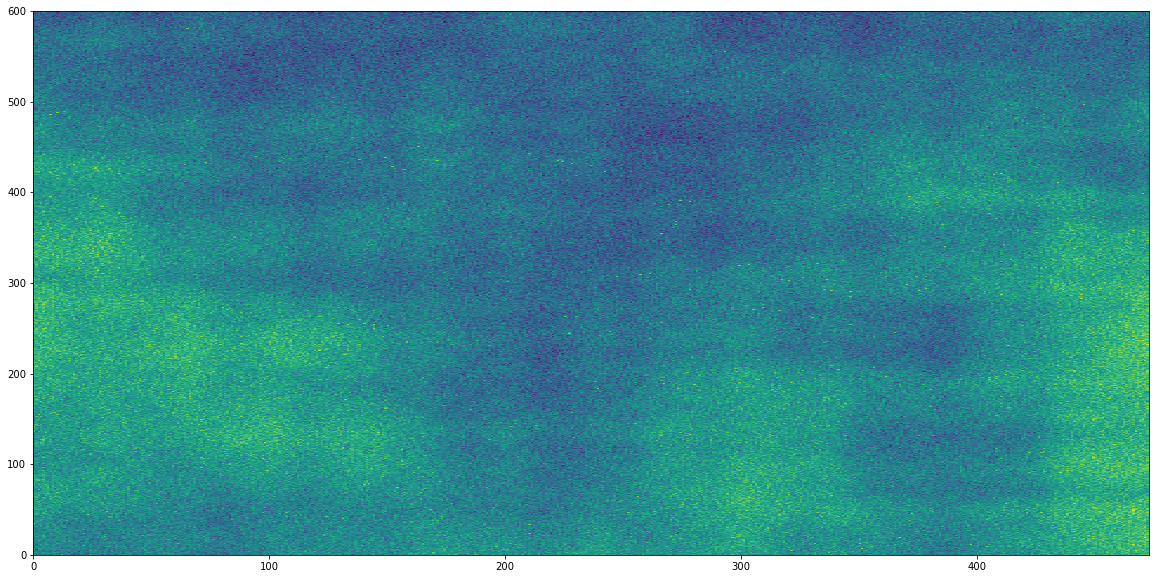

In [34]:
from pylbfgs import owlqn

def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx

# fractions of the scaled image to randomly sample at
sample_sizes = (0.2, 0.01)

# read original image
cwd = os.getcwd()#Gets current working directory
imgPath = os.path.join(cwd,"images","escher_waterfall.jpg") #Creates path to image
im = Image.open(imgPath) #Converts to grayscale
Xorig= np.asarray(im) #Converts to array
ny,nx,nchan = Xorig.shape

print(ny,nx,nchan)

# for each sample size
Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
for i,s in enumerate(sample_sizes):

    # create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices

    # for each color channel
    for j in range(nchan):

        # extract channel
        X = Xorig[:,:,j].squeeze()

        # create images of mask (for visualization)
        Xm = 255 * np.ones(X.shape)
        Xm.T.flat[ri] = X.T.flat[ri]
        masks[i][:,:,j] = Xm

        # take random samples of image, store them in a vector b
        b = X.T.flat[ri].astype(float)

        # perform the L1 minimization in memory
        Xat2 = owlqn(nx*ny, evaluate, None, 5)

        # transform the output back into the spatial domain
        Xat = Xat2.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)
        plt.pcolor(Xa)
        plt.draw
        Z[i][:,:,j] = Xa.astype('uint8')
        print(j)

(2, 600, 473, 3)


0

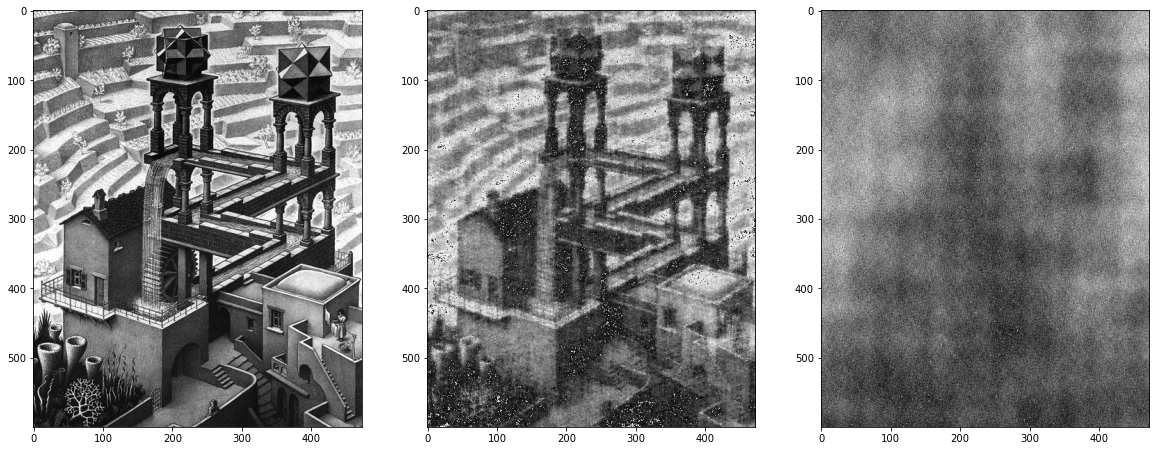

In [35]:
print(np.shape(Z))
Xa = Z[0][:,:,:]

plt.subplot(1,3,1)
plt.imshow(Xorig)

plt.subplot(1,3,2)
plt.imshow(Xa)

Xa = Z[1][:,:,:]

plt.subplot(1,3,3)
plt.imshow(Xa)